# Time Serie Analysis - Climate forecasting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns

sns.set(rc={'figure.figsize':(10, 8)})
sns.set_style('darkgrid', {'axes.linewidth': 2, 'axes.edgecolor':'black'})

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Data source

In [2]:
# Import dataset
train = pd.read_csv(r'dataset\DailyDelhiClimateTrain.csv')
test = pd.read_csv(r'dataset\DailyDelhiClimateTest.csv')

# train.dtypes


train['date'] = pd.to_datetime(train['date'])
train.set_index('date', inplace=True)

train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [3]:
# Check for any missing dates - None found
# From 2013-01-01    to    2017-01-01
# Only one observation in 2017, thus the last observation is removed.

# df.groupby(pd.PeriodIndex(df['date'], freq="M")).size()

In [4]:
# I would like to look at monthly averages. 
#train = df[:-1].groupby(pd.PeriodIndex(df[:-1]['date'], freq="M")).mean();
#train.head()

# Initial insight
Let us begin by exploring our variables. 

In [5]:
train.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


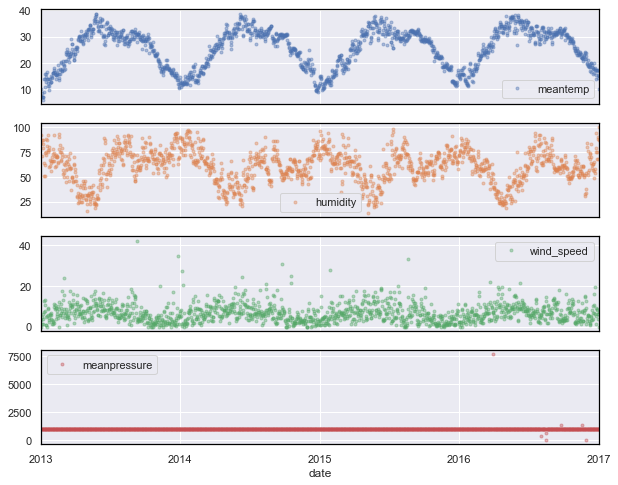

In [6]:
cols_plot = ['meanTemp', 'humidity', 'wind_speed', 'meanpressure']
train.plot(linestyle='None', alpha=0.4, marker='.', subplots = True);

### Remarks
* Seasionality within meantemp, humidity and wind_speed. 
* Outlier in meanpreassure. Potential outliers in wind_speed.

# 1. Investigating variables

## 1.1 Mean temperature

### 1.1.1 Heat map
Returning the daily values for a second, we can take a quick look into the daily mean temperature with a heat map. As seen in figure below, most of the warmer days reside in the middle of the year.

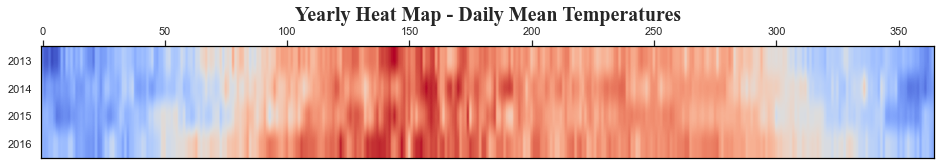

In [7]:
#groups = df[:-1].groupby(pd.PeriodIndex(df[:-1]['date'], freq="A"))
groups = train[:-1].groupby(pd.PeriodIndex(train[:-1].index.values, freq="A"))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group.reset_index().meantemp
axs = plt.matshow(years.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('coolwarm'));
plt.grid()
plt.title('Yearly Heat Map - Daily Mean Temperatures', fontname="Times New Roman", size=20, fontweight="bold")
plt.tick_params(axis='x', bottom=False)
plt.yticks(np.arange(4), ["2013", "2014", "2015", "2016"]);

### 1.1.2 Line plot
We have already seen a scatter plot of the monthly mean temperature, but let us plot our observations again and investigate. 

**Observations from the line plot:**
* Strong seasonal pattern.
* Potential trend.
* Non-stationary.

In [8]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


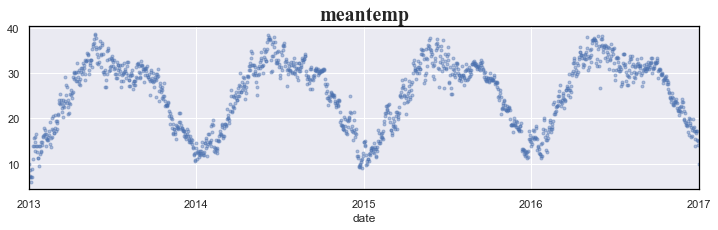

In [9]:
axs = train.loc[:, "meantemp"].plot(linestyle='None', alpha=0.4, marker='.', figsize=(12, 3));
axs.set_title('meantemp', fontname="Times New Roman", size=20, fontweight="bold");

### 1.1.3 Box-and-whisker plot
We can group our data by both months and year. 

**Observations from figure 1:**
* Strong seasonality.
* Potential outliers or structural breaks.

**Observations from figure 2:**
* No year seem to differ from another significantly. 

Our training period is quite short since we are looking back on 4 years. Longer periods could have had year-to-year fluctuations not being systematic and thus hard to model. For example, climate data from 1980 would probebly not be representative today. These structural breaks could suggest a benefit in dropping initial years of the training data set.

Note: Year 2017 only has one observation and will not be plotted.

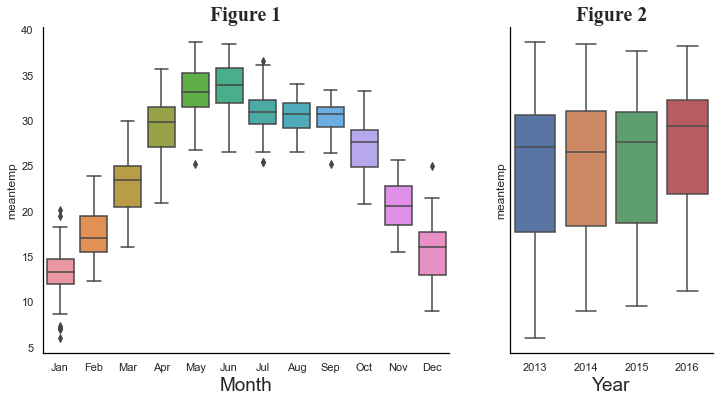

In [10]:
train['Month'] = train.index.strftime('%b')
train['Year'] = train.index.strftime('%Y')

f, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'width_ratios': [2, 1]})
sns.boxplot(x='Month', y='meantemp', data=train, ax=axs[0])
sns.boxplot(x='Year', y='meantemp', data=train[:-1], ax=axs[1])

for i in range(2):
    axs[i].set_facecolor('white')
    axs[i].xaxis.label.set_size(19)
    axs[i].spines.right.set_visible(False)
    axs[i].spines.top.set_visible(False)
    axs[i].set_title(f'Figure {i+1}', fontname="Times New Roman", size=20, fontweight="bold")

train = train.drop(columns=['Month', 'Year'])

In [11]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


### 1.1.4 Density plot
Density of our observations could provide knowledge regarding structure. 

**Observations from the KDE plot:**
* The distribution is not Gaussian.
* Distribution is right shifted, may be exponential or double Gaussian.

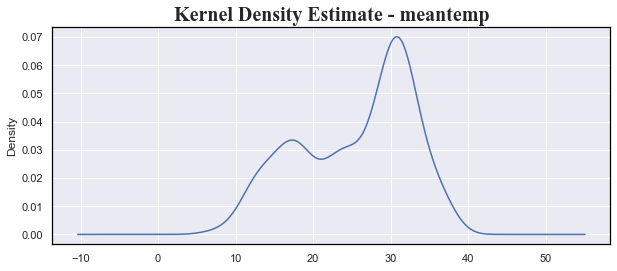

In [12]:
axs = train.loc[:, "meantemp"].plot(kind='kde', figsize=(10, 4))
axs.set_title('Kernel Density Estimate - meantemp', fontname="Times New Roman", size=20, fontweight="bold");

### ACF and PACF

Some observations from the ACF and PACF:
* Clear seasonal pattern in ACF.

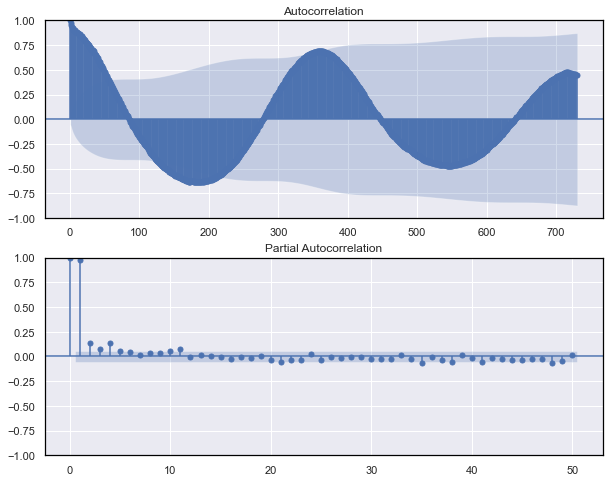

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(train.loc[:, "meantemp"], lags=365*2, ax=plt.gca());
plt.subplot(212)
plot_pacf(train.loc[:, "meantemp"], lags=50, ax=plt.gca(), method='ywm');

### Detrend

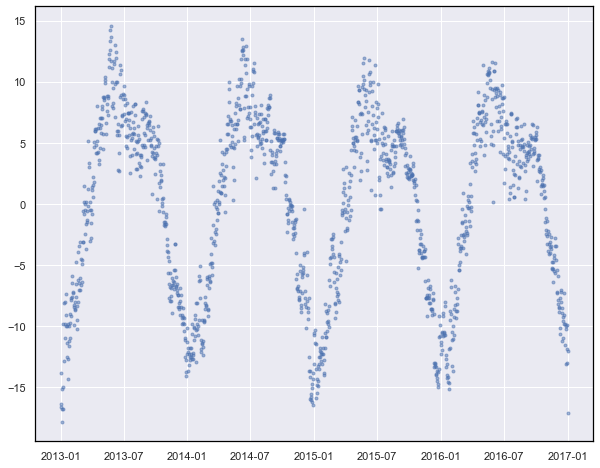

In [14]:
from scipy import signal

temp_d = signal.detrend(train['meantemp'].values)
#plt.plot(train.index.strftime('%Y-%m'), temp_d, linestyle='None', alpha=0.4, marker='.')
plt.plot(train.index.values, temp_d, linestyle='None', alpha=0.5, marker='.')
#plt.set_title('meantemp', fontname="Times New Roman", size=20, fontweight="bold");

In [15]:
# Seasonal differenced
temp_d12 = np.diff(temp_d, 365)

In [25]:
temp_d12[:]

array([ 1.69300373e+109, -1.86291455e+109,  2.02391775e+109, ...,
        2.96574340e+109, -3.02971935e+109,  3.08297591e+109])

In [34]:
train.index[:-365]

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2015-12-24', '2015-12-25', '2015-12-26', '2015-12-27',
               '2015-12-28', '2015-12-29', '2015-12-30', '2015-12-31',
               '2016-01-01', '2016-01-02'],
              dtype='datetime64[ns]', name='date', length=1097, freq=None)

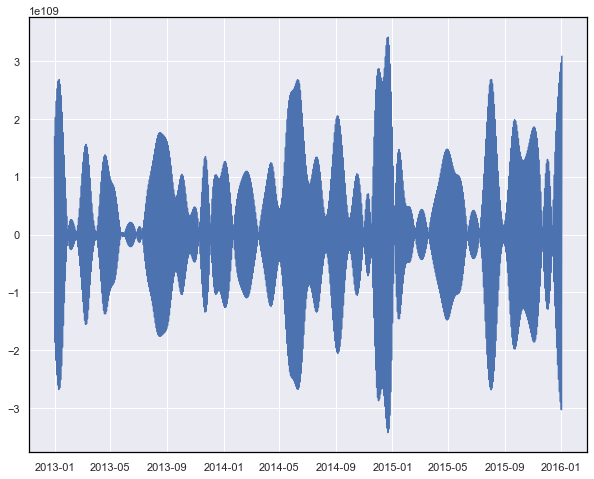

In [35]:
plt.plot(train.index[:-365], temp_d12);

**Augmented Dickey-Fuller Test**

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(temp_d12, autolag='AIC')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -142.157470
p-value: 0.000000


# 2. ARIMA Models

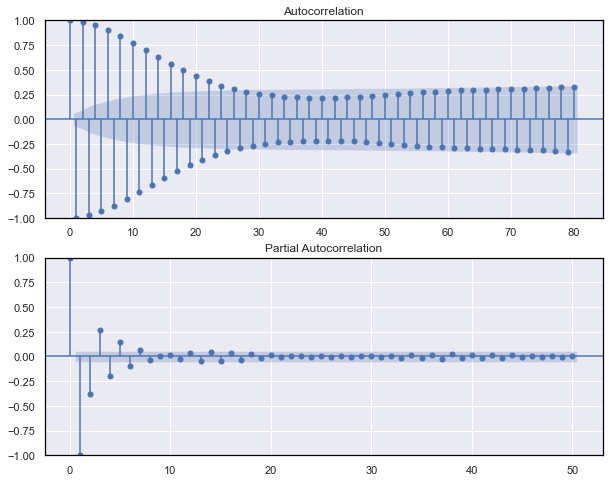

In [40]:
plt.figure()
plt.subplot(211)
plot_acf(temp_d12, lags=80, ax=plt.gca());
plt.subplot(212)
plot_pacf(temp_d12, lags=50, ax=plt.gca(), method='ywm');

### Manually configured ARIMA

Looking at the ACF plot, significant spikes at first and alterning behavior would indicate a higher order autoregressive term. Using the PACF, it would suggest the use of 2 AR terms.

A moving average term could prove useful, but let us start by having none in our model.

In [41]:
from statsmodels.tsa.arima.model import ARIMA

# Train AR(2) model
model = ARIMA(train.meantemp.values, order=(0,0,7))
model_fit = model.fit()

fc = model_fit.get_forecast(12)  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean)
print(fc_series)

print(model_fit.summary())

0     10.942904
1     11.986014
2     14.797858
3     17.534800
4     20.238167
5     22.253696
6     24.000319
7     25.432828
8     25.432828
9     25.432828
10    25.432828
11    25.432828
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1462
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -3115.305
Date:                Tue, 08 Mar 2022   AIC                           6248.609
Time:                        22:44:52   BIC                           6296.197
Sample:                             0   HQIC                          6266.360
                               - 1462                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
con

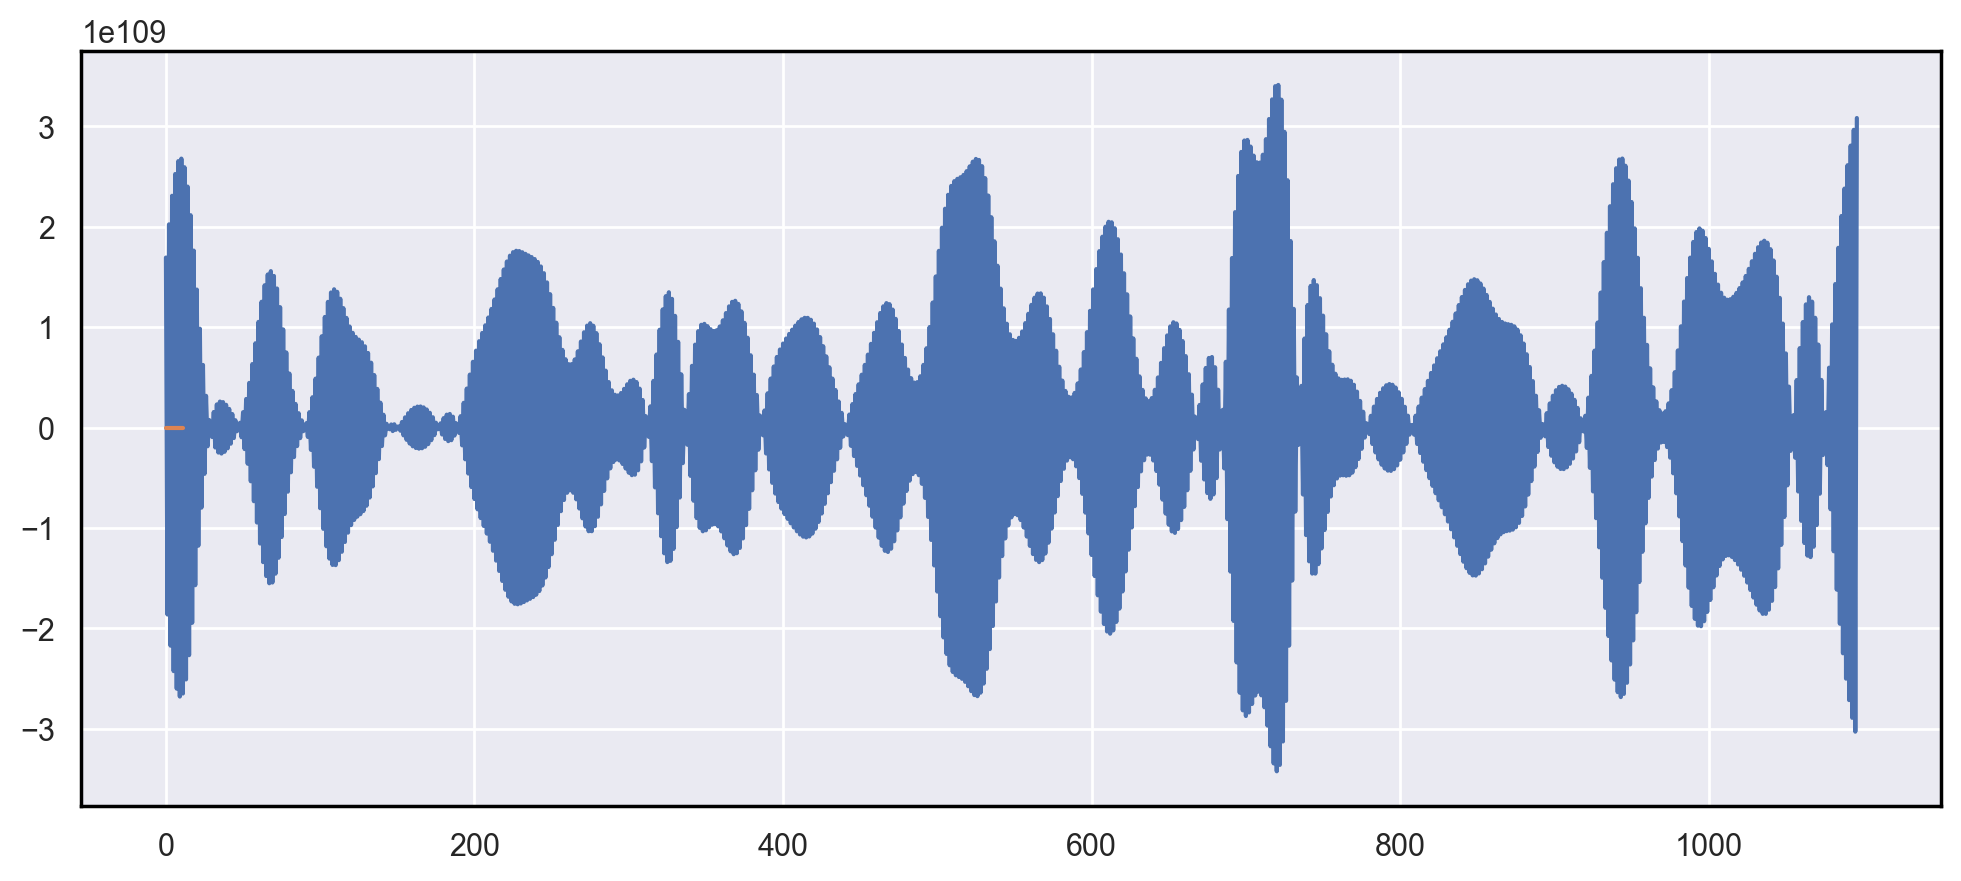

In [20]:
plt.figure(figsize=(12,5), dpi=200)
plt.plot(temp_d12, label='training')
plt.plot(fc_series, label='forecast')